## Changed Model archietecter from two dense 

Test 1
global avg -> dropout ->dens(27)
image flop only horizontoal 
Network trained unstable way. Val_loss and accuraccy fluctuated.
Test 47%

Test 2
image flip horizontal vertical
global avg -> dropout ->dens(27)
Test 34%

Test 3
image flop only horizontoal 
global avg -> batchnorm ->dens(27)
end in 7 Test 51% --> 44%

Test 4
image flip horizontal vertical
global avg -> batchnorm ->dens(27)
35%?

Test 5
image flip horizontal 
global avg -> dense(512)-> dropout(0.5) ->dense(27)
test 60%

Test 6
image flip horizontal vertical
global avg -> dense(512)-> dropout(0.5) ->dense(27)
test 46%

Test 7
Full retrain based on imagenet weight
image flip horizontal 
global avg -> dense(512)-> dropout(0.5) ->dense(27)
test 80%

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()
tf.__version__

'1.14.0'

In [2]:
import pandas as pd

train_df = pd.read_pickle('./mvc_train.pkl')
test_df = pd.read_pickle('./mvc_test.pkl')

In [3]:
train_df.sample(10)

,filename,attributes
24166,category/Coats_Outerwear/p8533380_s3168321_v1.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
93884,category/Coats_Outerwear/p8541416_s3190760_v2.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
93141,category/Sweaters/p8316938_s2667633_v4.jpg,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
40924,category/Shirts_Tops/p8578262_s3279991_v3.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
4707,category/Shirts_Tops/p8578285_s3280001_v0.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
31053,category/Jeans/p8534201_s3170533_v1.jpg,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
78338,category/Shirts_Tops/p8539356_s3184619_v2.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ..."
71204,category/Shirts_Tops/p8329893_s2708043_v1.jpg,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
62957,category/Jeans/p8619191_s3363728_v2.jpg,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
28492,category/Shirts_Tops/p8612762_s3352358_v3.jpg,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


In [4]:
label = ['BoardShorts',
'ButtonUpShirts',
'Crew',
'Denim',
'FloralPrint',
'GraphicPrint',
'Halter',
'Hood',
'HorizontalStripes',
'Insulated',
'Leggings',
'LongSleeves',
'Mesh',
'Plaid',
'Polos',
'Scoop',
'ShortSleeves',
'Sleeveless',
'SnowPants',
'Stripes',
'VerticalStripes',
'Vests',
'Vneck',
'Zipper',
'halfZip',
'quarter3Zip',
'quarterZip']

In [5]:
IMG_SIZE = 256
CROP_SIZE = 224

def train_preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image/127.5) - 1
    image = tf.image.random_crop(image, [CROP_SIZE, CROP_SIZE, 3])
    #image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    
    #image /= 255.0  # normalize to [0,1] range
    

    #encoded_png_io = io.BytesIO(encoded_png)
    #image = pil.open(encoded_png_io)
    #image = np.asarray(image)    

    return image

def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [CROP_SIZE, CROP_SIZE])
    #image = tf.image.random_crop(image, [CROP_SIZE, CROP_SIZE, 3])
    image = (image/127.5) - 1
    #image /= 255.0  # normalize to [0,1] range
    

    #encoded_png_io = io.BytesIO(encoded_png)
    #image = pil.open(encoded_png_io)
    #image = np.asarray(image)    

    return image

In [6]:
def train_load_and_preprocess_image(path):
    image = tf.read_file(path)
    return train_preprocess_image(image)

def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

In [7]:
import numpy as np
train_paths = train_df['filename'].tolist()
train_label = np.asarray(train_df['attributes'].tolist())

test_paths = test_df['filename'].tolist()
test_label = np.asarray(test_df['attributes'].tolist())

In [8]:
train_path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
test_path_ds = tf.data.Dataset.from_tensor_slices(test_paths)

train_image_ds = train_path_ds.map(train_load_and_preprocess_image)
test_image_ds = test_path_ds.map(load_and_preprocess_image)

In [9]:
train_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_label, tf.int32))
test_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_label, tf.int32))

In [10]:
train_image_label_ds = tf.data.Dataset.zip((train_image_ds, train_label_ds))
print(train_image_label_ds)
test_image_label_ds = tf.data.Dataset.zip((test_image_ds, test_label_ds))
print(test_image_label_ds)

<DatasetV1Adapter shapes: ((224, 224, 3), (27,)), types: (tf.float32, tf.int32)>
<DatasetV1Adapter shapes: ((224, 224, 3), (27,)), types: (tf.float32, tf.int32)>


In [11]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.

train_image_label_ds = train_image_label_ds.shuffle(buffer_size=512).repeat()
train_image_label_ds = train_image_label_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
train_image_label_ds

<DatasetV1Adapter shapes: ((?, 224, 224, 3), (?, 27)), types: (tf.float32, tf.int32)>

In [12]:
test_image_label_ds = test_image_label_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_image_label_ds

<DatasetV1Adapter shapes: ((?, 224, 224, 3), (?, 27)), types: (tf.float32, tf.int32)>

In [13]:
for image_batch, label_batch in train_image_label_ds:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 27)


In [14]:
IMG_SHAPE = (CROP_SIZE, CROP_SIZE, 3)


#base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(input_shape=IMG_SHAPE,
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#base_model = tf.keras.applications.nasnet.NASNetMobile(input_shape=IMG_SHAPE,
#base_model = tf.keras.applications.densenet.DenseNet201(input_shape=IMG_SHAPE,
#base_model = tf.keras.applications.nasnet.NASNetLarge(input_shape=IMG_SHAPE,
#base_model = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
#base_model = tf.keras.applications.xception.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [15]:
#with tf.device('/cpu:0'): 
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [16]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.input_shape)

0 [(None, 224, 224, 3)]
1 (None, 224, 224, 3)
2 (None, 225, 225, 3)
3 (None, 112, 112, 32)
4 (None, 112, 112, 32)
5 (None, 112, 112, 32)
6 (None, 112, 112, 32)
7 (None, 112, 112, 32)
8 (None, 112, 112, 32)
9 (None, 112, 112, 16)
10 (None, 112, 112, 16)
11 (None, 112, 112, 96)
12 (None, 112, 112, 96)
13 (None, 112, 112, 96)
14 (None, 113, 113, 96)
15 (None, 56, 56, 96)
16 (None, 56, 56, 96)
17 (None, 56, 56, 96)
18 (None, 56, 56, 24)
19 (None, 56, 56, 24)
20 (None, 56, 56, 144)
21 (None, 56, 56, 144)
22 (None, 56, 56, 144)
23 (None, 56, 56, 144)
24 (None, 56, 56, 144)
25 (None, 56, 56, 144)
26 (None, 56, 56, 24)
27 [(None, 56, 56, 24), (None, 56, 56, 24)]
28 (None, 56, 56, 24)
29 (None, 56, 56, 144)
30 (None, 56, 56, 144)
31 (None, 56, 56, 144)
32 (None, 57, 57, 144)
33 (None, 28, 28, 144)
34 (None, 28, 28, 144)
35 (None, 28, 28, 144)
36 (None, 28, 28, 32)
37 (None, 28, 28, 32)
38 (None, 28, 28, 192)
39 (None, 28, 28, 192)
40 (None, 28, 28, 192)
41 (None, 28, 28, 192)
42 (None, 28, 28, 

In [17]:
#with tf.device('/cpu:0'): 
#base_model.trainable = False
'''
for layer in base_model.layers[:121]:
    layer.trainable = False
    
for layer in base_model.layers[121:]:
    layer.trainable = True
'''
base_model.trainable = True
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
#dropout_layer = tf.keras.layers.Dropout(0.5)
#dropout_batch = dropout_layer(feature_batch_average)
#batchnorm_layer = tf.keras.layers.BatchNormalization()
#batchnorm = batchnorm_layer(feature_batch_average)
#print(batchnorm.shape)

In [19]:

mid_layer = tf.keras.layers.Dense(512, activation='relu')
mid_batch = mid_layer(feature_batch_average)
dropout_layer = tf.keras.layers.Dropout(0.5)
dropout_batch = dropout_layer(mid_batch)
#prediction_layer = tf.keras.layers.Dense(27, activation='sigmoid')
prediction_layer = tf.keras.layers.Dense(27)
prediction_batch = prediction_layer(dropout_batch)
print(prediction_batch.shape)

(32, 27)


In [20]:
nb_train_samples = len(train_paths) 
nb_val_samples = len(test_paths) 

steps_per_epoch = nb_train_samples // BATCH_SIZE
validation_steps=nb_val_samples//BATCH_SIZE
nb_val_samples

27348

In [21]:
def weighted_loss(target, prediction):
    batch = tf.shape(target)[0]
    
    #print(batch)
    target = tf.cast(target, tf.float32)
    weight = 1-tf.divide(tf.reduce_sum(target,0, keepdims=True),tf.cast(batch, tf.float32))
    #print(weight)
    #print(loss)
    return tf.nn.weighted_cross_entropy_with_logits(labels=target, logits=prediction, pos_weight=weight)
    
    #return tf.nn.weighted_cross_entropy_with_logits(targets=tf.cast(y, tf.float32), logits=y_, pos_weight=tf.cast(weight, tf.float32))

when val is very slow refer this [page](https://github.com/keras-team/keras/issues/6101)

In [22]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    mid_layer,
    dropout_layer,
    prediction_layer
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 27)                13851     
Total params: 2,927,707
Trainable params: 2,893,595
Non-trainable params: 34,112
_________________________________________________________________


In [24]:
#parallel_model = multi_gpu_model(model, gpus=2)
callbacks = [
    # Interrupt training if `val_loss` stops improving for over 2 epochs
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    tf.keras.callbacks.ModelCheckpoint(filepath='./mobilev2_full/finetune_aug.top.h5', save_best_only=True),
    # Write TensorBoard logs to `./logs` directory
    tf.keras.callbacks.TensorBoard(log_dir='./mobilev2_full/logs')
]

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss=weighted_loss, optimizer='adam', metrics=[tf.keras.metrics.BinaryAccuracy()])
#model.load_weights('./mobilev2_2019072004/weights')


In [25]:
history = model.fit(train_image_label_ds, steps_per_epoch=steps_per_epoch, epochs=20, validation_data=test_image_label_ds, validation_steps=validation_steps, \
          workers=4, use_multiprocessing=True , callbacks=callbacks)

Epoch 1/20
3418/3418 [==============================] - 2044s 598ms/step - loss: 0.0812 - binary_accuracy: 0.9680 - val_loss: 0.1492 - val_binary_accuracy: 0.9509
Epoch 2/20
3418/3418 [==============================] - 1990s 582ms/step - loss: 0.0662 - binary_accuracy: 0.9738 - val_loss: 0.0996 - val_binary_accuracy: 0.9632
Epoch 3/20
3418/3418 [==============================] - 1991s 582ms/step - loss: 0.0618 - binary_accuracy: 0.9755 - val_loss: 0.0959 - val_binary_accuracy: 0.9635
Epoch 4/20
3418/3418 [==============================] - 1989s 582ms/step - loss: 0.0585 - binary_accuracy: 0.9766 - val_loss: 0.0620 - val_binary_accuracy: 0.9754
Epoch 5/20
3418/3418 [==============================] - 1987s 581ms/step - loss: 0.0560 - binary_accuracy: 0.9776 - val_loss: 0.0735 - val_binary_accuracy: 0.9720
Epoch 6/20
3418/3418 [==============================] - 1990s 582ms/step - loss: 0.0542 - binary_accuracy: 0.9783 - val_loss: 0.0619 - val_binary_accuracy: 0.9748
Epoch 7/20
3418/3418 [

In [26]:
model.save('./mobilev2_2019072006/finetune_aug.h5')

In [27]:
model.save_weights('./mobilev2_2019072006/weights')

In [66]:
path='./rename/p8604244_s3328909_v0.jpg'
image = tf.read_file(path)
image = tf.image.decode_jpeg(image, channels=3)
image = tf.image.resize(image, [224,224])
image = image/127.5 - 1 # normalize to [0,1] range
pred = model.predict(image[np.newaxis, ...])
indexes = np.where(pred[0,:]> 0.5)
attr=pd.Series(label)
attr.iloc[indexes]

17    Sleeveless
22         Vneck
dtype: object

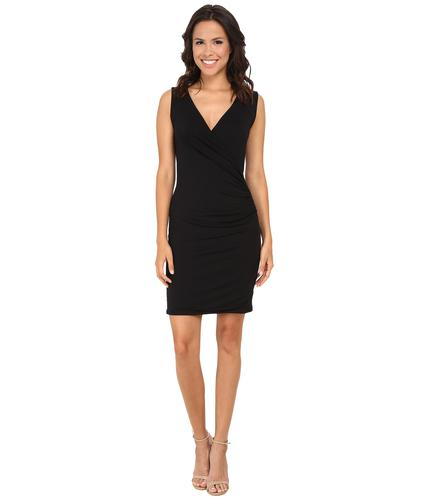

In [67]:
from IPython.display import Image
Image(path)

Text(0.5, 0, 'epoch')

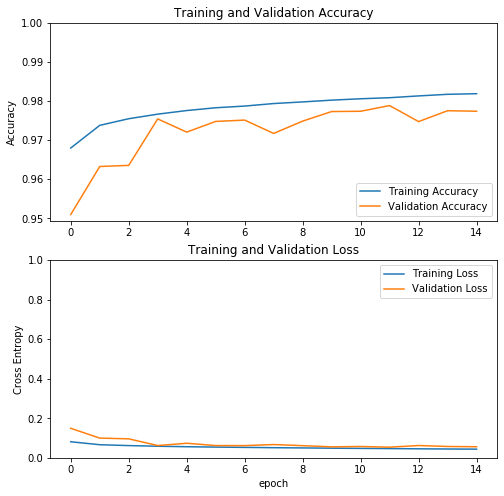

In [33]:
import matplotlib.pyplot as plt


acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')